# Autoencoders

In [2]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter


seed=1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

# Dataset
MNIST dataset will be used

In [3]:
from IPython.core.display import HTML
from markdown import markdown
import os

print('Run the following command in terminal:')
print('tensorboard --logdir runs --bind_all')

markdown_string = f"Tensorboard URL: [https://mlhep.coresearch.club/{os.environ['COCALC_PROJECT_ID']}/server/6006/](https://mlhep.coresearch.club/{os.environ['COCALC_PROJECT_ID']}/server/6006/)"
writer = SummaryWriter('runs/')

HTML("<p>{}</p>".format(markdown(markdown_string)))

Run the following command in terminal:
tensorboard --logdir runs --bind_all


In [4]:
batch_size=128
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

mnist_transforms = transforms.Compose([ 
    transforms.ToTensor(), # PIL Image -> Tensor
#     transforms.Lambda(lambda x: x/255.),
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../../share', train=True,
                   transform=mnist_transforms),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../../share', train=False, transform=mnist_transforms),
    batch_size=batch_size, shuffle=True, **kwargs)

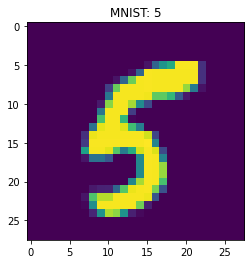

In [5]:
image, label = next(iter(train_loader))
image.shape
%matplotlib inline
import matplotlib.pyplot as plt
indx = 0
plt.title(f'MNIST: {label[indx].item()}')
plt.imshow(image[indx].squeeze(0))

## Autoencoder model
![](http://bjlkeng.github.io/images/autoencoder_structure.png)

In [5]:
class AE(nn.Module):
    def __init__(self, hidden_size=20):
        super(AE, self).__init__()
        self.hidden_size = hidden_size

        # Define self.encoder and self.decoder ()

        self.encoder = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),
            nn.Linear(400, hidden_size)
        )

        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid()
        )

    def encode(self, x): return self.encoder(x.view(-1, 28*28))
    def decode(self, z): return self.decoder(z).view(-1,28,28)
    def forward(self, x): return self.decode(self.encode(x))
    def sample(self, size):
        return self.decode(torch.randn(size, self.hidden_size)).to(self.device)
    @property
    def device(self): return next(self.parameters()).device


model = AE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [6]:
for batch_idx, (data, _) in enumerate(train_loader):
    data_recon = model(data.to(device))
    assert data_recon.shape == torch.Size([128,28,28])
    break

## Train model

In [7]:
def recon_loss(recon_x, x):
    # YOUR CODE HERE
    MSE = F.mse_loss(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    return MSE


log_interval=10
epochs=30

def train(epoch):
    model.train()
    train_loss = 0
    # YOUR CODE HERE
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = recon_loss(recon_batch, data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    train_loss /= len(train_loader.dataset)
    #writer.add_scalar('ae/train_loss', train_loss, epoch)

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss))


def test(epoch):
    model.eval()
    test_loss = 0
    # YOUR CODE HERE
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch = model(data)
            test_loss += recon_loss(recon_batch, data).item()
    test_loss /= len(test_loader.dataset)
    writer.add_scalar('ae/test_loss', test_loss)
    return test_loss

for epoch in range(1, epochs + 1):
    train(epoch)
    test_loss = test(epoch)
    with torch.no_grad():
        sample_size=64
        sample = model.sample(sample_size).cpu()
        img = make_grid(sample.view(-1,1,28,28))
        #writer.add_image('ae/test_image', img, epoch)

====> Epoch: 1 Average loss: 27.7742


====> Epoch: 2 Average loss: 11.3964


====> Epoch: 3 Average loss: 9.6592


====> Epoch: 4 Average loss: 8.7898


====> Epoch: 5 Average loss: 8.2279


====> Epoch: 6 Average loss: 7.8070


====> Epoch: 7 Average loss: 7.4830


====> Epoch: 8 Average loss: 7.2249


====> Epoch: 9 Average loss: 7.0058


====> Epoch: 10 Average loss: 6.8255


====> Epoch: 11 Average loss: 6.6618


====> Epoch: 12 Average loss: 6.5311


====> Epoch: 13 Average loss: 6.4025


====> Epoch: 14 Average loss: 6.2952


====> Epoch: 15 Average loss: 6.1974


====> Epoch: 16 Average loss: 6.1139


====> Epoch: 17 Average loss: 6.0282


====> Epoch: 18 Average loss: 5.9659


====> Epoch: 19 Average loss: 5.8868


====> Epoch: 20 Average loss: 5.8337


====> Epoch: 21 Average loss: 5.7778


====> Epoch: 22 Average loss: 5.7255


====> Epoch: 23 Average loss: 5.6727


====> Epoch: 24 Average loss: 5.6263


====> Epoch: 25 Average loss: 5.5902


====> Epoch: 26 Average loss: 5.5442


====> Epoch: 27 Average loss: 5.5117


====> Epoch: 28 Average loss: 5.4838


====> Epoch: 29 Average loss: 5.4404


====> Epoch: 30 Average loss: 5.4120


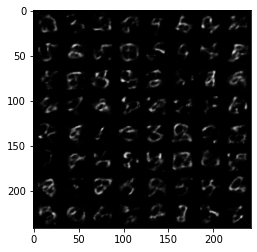

In [8]:
img = (img.permute((1,2,0))*255).detach().cpu().numpy().astype('uint8').squeeze()
plt.imshow(img)

# Denoising autoencoder

In [9]:
model = AE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def recon_loss(recon_x, x):
    # YOUR CODE HERE
    MSE = F.mse_loss(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    return MSE


# log_interval=10
epochs=30

def train(epoch,var=1e-2):
    model.train()
    train_loss = 0
    # Add noise to image in training stage with "var" variance
    # YOUR CODE HERE
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data + var * torch.randn_like(data))
        loss = recon_loss(recon_batch, data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    train_loss /= len(train_loader.dataset)
    #writer.add_scalar('dae/train_loss', train_loss)

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss))



def test(epoch):
    model.eval()
    test_loss = 0
    # YOUR CODE HERE
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch = model(data)
            test_loss += recon_loss(recon_batch, data).item()
    test_loss /= len(test_loader.dataset)
    writer.add_scalar('dae/test_loss', test_loss)
    return test_loss

for epoch in range(1, epochs + 1):
    train(epoch)
    test_loss = test(epoch)
    with torch.no_grad():
        sample_size=64
        sample = model.sample(sample_size).cpu()
        img = make_grid(sample.view(-1,1,28,28))
        #writer.add_image('dae/test_image', img, epoch)


====> Epoch: 1 Average loss: 27.9184


====> Epoch: 2 Average loss: 11.3667


====> Epoch: 3 Average loss: 9.6269


====> Epoch: 4 Average loss: 8.7570


====> Epoch: 5 Average loss: 8.1695


====> Epoch: 6 Average loss: 7.7409


====> Epoch: 7 Average loss: 7.4007


====> Epoch: 8 Average loss: 7.1332


====> Epoch: 9 Average loss: 6.9158


====> Epoch: 10 Average loss: 6.7230


====> Epoch: 11 Average loss: 6.5703


====> Epoch: 12 Average loss: 6.4339


====> Epoch: 13 Average loss: 6.3194


====> Epoch: 14 Average loss: 6.2174


====> Epoch: 15 Average loss: 6.1291


====> Epoch: 16 Average loss: 6.0463


====> Epoch: 17 Average loss: 5.9778


====> Epoch: 18 Average loss: 5.9036


====> Epoch: 19 Average loss: 5.8431


====> Epoch: 20 Average loss: 5.7888


====> Epoch: 21 Average loss: 5.7426


====> Epoch: 22 Average loss: 5.6890


====> Epoch: 23 Average loss: 5.6438


====> Epoch: 24 Average loss: 5.5986


====> Epoch: 25 Average loss: 5.5658


====> Epoch: 26 Average loss: 5.5302


====> Epoch: 27 Average loss: 5.4951


====> Epoch: 28 Average loss: 5.4589


====> Epoch: 29 Average loss: 5.4327


====> Epoch: 30 Average loss: 5.3986


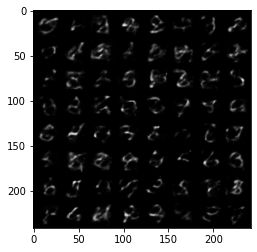

In [10]:
img = (img.permute((1,2,0))*255).detach().cpu().numpy().astype('uint8').squeeze()
plt.imshow(img)

# Sparse autoencoder

In [7]:
# Implement Sparse autoencoder with L1 regularization on each intermediate activation

class SparseAE(nn.Module):
    def __init__(self, hidden_size=20):
        super(SparseAE, self).__init__()
        self.hidden_size = hidden_size

        # Define self.encoder and self.decoder ()

        # YOUR CODE HERE
        self.encoder = nn.Sequential(
            nn.Linear(784,400),
            nn.ReLU(),
            nn.Linear(400, hidden_size)
        )

        self.decoder = nn.Sequential(
            nn.Linear(hidden_size,400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid()
        )

    def encode(self, x):
        # YOUR CODE HERE
        return self.encoder(x.view(-1, 28*28))
    def decode(self, z): return self.decoder(z).view(-1,28,28)
    def forward(self, x):
        # YOUR CODE HERE
        reg_loss = 0 # accumulate L1
        values = x.view(-1, 28*28)
        for l in self.encoder.children():
            values = F.relu(l(values))
            reg_loss += torch.mean(torch.abs(values))
        return self.decode(values), reg_loss
    def sample(self, size):
        # YOUR CODE HERE
        return self.decode(torch.randn(size, self.hidden_size).to(self.device))
    @property
    def device(self): return next(self.parameters()).device

model = SparseAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def recon_loss(recon_x, x):
    # YOUR CODE HERE
    MSE = F.mse_loss(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    return MSE


# log_interval=10
epochs=30
var = 1e-2

def train(epoch):
    model.train()
    train_loss, train_loss_reg = 0, 0
    # YOUR CODE HERE
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, reg_loss = model(data + var * torch.randn_like(data))
        loss = recon_loss(recon_batch, data)
        loss.backward(retain_graph=True)
        reg_loss.backward()
        train_loss += loss.item()
        train_loss_reg += reg_loss.item()
        optimizer.step()

    train_loss /= len(train_loader.dataset)
    train_loss_reg /= len(train_loader.dataset)
    #writer.add_scalar('dae/train_loss', train_loss)
    #writer.add_scalar('dae/train_loss_reg', train_loss_reg)

    print('====> Epoch: {} Average loss: {:.4f} Reg loss: {:.4f}'.format(epoch, train_loss, train_loss_reg))


def test(epoch):
    model.eval()
    test_loss, test_loss_reg = 0, 0
    # YOUR CODE HERE
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, reg_loss = model(data)
            test_loss += recon_loss(recon_batch, data).item()
            test_loss_reg += reg_loss.item()
    test_loss /= len(test_loader.dataset)
    test_loss_reg /= len(test_loader.dataset)
    #writer.add_scalar('dae/test_loss', test_loss)
    return test_loss, test_loss_reg

for epoch in range(1, epochs + 1):
    train(epoch)
    test_loss, test_loss_reg = test(epoch)
    with torch.no_grad():
        sample_size=64
        sample = model.sample(sample_size).cpu()
        img = make_grid(sample.view(-1,1,28,28))
        #writer.add_image('sae/test_image', img, epoch)

====> Epoch: 1 Average loss: 32.8180 Reg loss: 0.0391


====> Epoch: 2 Average loss: 19.0362 Reg loss: 0.0459


====> Epoch: 3 Average loss: 17.1982 Reg loss: 0.0488


====> Epoch: 4 Average loss: 16.1509 Reg loss: 0.0506


====> Epoch: 5 Average loss: 15.4296 Reg loss: 0.0516


====> Epoch: 6 Average loss: 14.8948 Reg loss: 0.0520


====> Epoch: 7 Average loss: 14.4929 Reg loss: 0.0519


====> Epoch: 8 Average loss: 14.1487 Reg loss: 0.0518


====> Epoch: 9 Average loss: 13.8755 Reg loss: 0.0516


====> Epoch: 10 Average loss: 13.6490 Reg loss: 0.0512


====> Epoch: 11 Average loss: 13.4541 Reg loss: 0.0509


====> Epoch: 12 Average loss: 13.2787 Reg loss: 0.0505


====> Epoch: 13 Average loss: 13.1210 Reg loss: 0.0504


====> Epoch: 14 Average loss: 12.9921 Reg loss: 0.0499


====> Epoch: 15 Average loss: 12.8659 Reg loss: 0.0496


====> Epoch: 16 Average loss: 12.7525 Reg loss: 0.0493


====> Epoch: 17 Average loss: 12.6480 Reg loss: 0.0490


====> Epoch: 18 Average loss: 12.5525 Reg loss: 0.0486


====> Epoch: 19 Average loss: 12.4565 Reg loss: 0.0484


====> Epoch: 20 Average loss: 12.3742 Reg loss: 0.0479


====> Epoch: 21 Average loss: 12.2904 Reg loss: 0.0478


====> Epoch: 22 Average loss: 12.2236 Reg loss: 0.0475


====> Epoch: 23 Average loss: 12.1433 Reg loss: 0.0471


====> Epoch: 24 Average loss: 12.0763 Reg loss: 0.0469


====> Epoch: 25 Average loss: 12.0098 Reg loss: 0.0466


====> Epoch: 26 Average loss: 11.9492 Reg loss: 0.0463


====> Epoch: 27 Average loss: 11.8894 Reg loss: 0.0461


====> Epoch: 28 Average loss: 11.8299 Reg loss: 0.0459


====> Epoch: 29 Average loss: 11.7903 Reg loss: 0.0456


====> Epoch: 30 Average loss: 11.7359 Reg loss: 0.0452


In [8]:
### BEGIN HIDDEN TESTS
# students will NOT see these extra tests
assert test_loss < 12
assert test_loss_reg < 1
### END HIDDEN TESTS

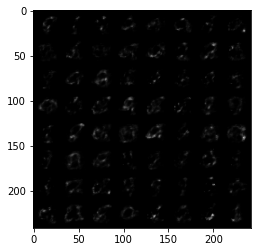

In [9]:
img = (img.permute((1,2,0))*255).detach().cpu().numpy().astype('uint8').squeeze()
plt.imshow(img)

# Links

[Simple explanation of AE](http://bjlkeng.github.io/posts/autoregressive-autoencoders/)

[Sparse autoencoder](https://debuggercafe.com/sparse-autoencoders-using-l1-regularization-with-pytorch/)

[Denoising autoencoder](https://towardsdatascience.com/denoising-autoencoders-explained-dbb82467fc2)